# PINN DeepXDE solution for 2D Navier Stokes equation

<img src="../images/navier_stockes_2d.png" width="25%">

<img src="../images/navier_stockes_2d_v2.png" width="25%">
<img src="../images/navier_stockes_2d_v3.png" width="25%">


In [1]:
import tensorflow as tf
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt

Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


Instructions for updating:
non-resource variables are not supported in the long term


## Setting geometry 

<img src="../images/problem_statement_NS.png" width="25%">


In [2]:
rho = 1  # fluid density
mu = 1  
u_in = 1
D = 1
L = 2

In [3]:
geom = dde.geometry.Rectangle(xmin=[-L/2, -D/2], xmax=[L/2, D/2])

## Set Boundary Conditions

In [6]:
def boundary_wall(X, on_boundary):
    print("X", X)
    print("on_boundary", on_boundary)

    on_wall = np.logical_and(np.logical_or(np.isclose(X[1], -D/2, rtol=1e-05, atol=1e-08), np.isclose(X[1], D/2, rtol=1e-05, atol=1e-08)), on_boundary)

    return on_wall

def boundary_inlet(X, on_boundary):
    on_inlet = np.logical_and(np.isclose(X[0], -L/2, rtol=1e-05, atol=1e-08), on_boundary)
    return on_inlet

def boundary_outlet(X, on_boundary):
    on_outlet = np.logical_and(np.isclose(X[0], L/2, rtol=1e-05, atol=1e-08), on_boundary)
    return on_outlet

In [7]:
bc_wall_u = dde.DirichletBC(geom, lambda X : 0., boundary_wall, component=0)  # component = 0 => u
bc_wall_v = dde.DirichletBC(geom, lambda X : 0., boundary_wall, component=1)  # component = 1 => v

bc_inlet_u = dde.DirichletBC(geom, lambda X : u_in, boundary_inlet, component=0)
bc_inlet_v = dde.DirichletBC(geom, lambda X : 0,    boundary_inlet, component=1)

bc_outlet_p = dde.DirichletBC(geom, lambda X : 0,   boundary_outlet, component=2) # component = 2 => P (pressure)
bc_outlet_v = dde.DirichletBC(geom, lambda X : 0,   boundary_outlet, component=1)

## Define the network and the pde

In [8]:
def pde(x, u):
    
    u_vel, v_vel, p = u[:, 0:1], u[:, 1:2], u[:, 2:]
    
    du_x = dde.grad.jacobian(u, x, i=0, j=0)
    du_y = dde.grad.jacobian(u, x, i=0, j=1)
    dv_x = dde.grad.jacobian(u, x, i=1, j=0)
    dv_y = dde.grad.jacobian(u, x, i=1, j=1)
    dp_x = dde.grad.jacobian(u, x, i=2, j=0)
    dp_y = dde.grad.jacobian(u, x, i=2, j=1)

    du_xx = dde.grad.hessian(u, x, component=0, i=0, j=0)
    du_yy = dde.grad.hessian(u, x, component=0, i=1, j=1)  # i=1, j=1 because yy
    dv_xx = dde.grad.hessian(u, x, component=1, i=0, j=0)
    dv_yy = dde.grad.hessian(u, x, component=1, i=1, j=1)

    pde_u = u_vel * du_x + v_vel * du_y + (1 / rho) * dp_x - (mu/rho) * (du_xx + du_yy)
    pde_v = u_vel * dv_x + v_vel * dv_y + (1 / rho) * dp_y - (mu/rho) * (dv_xx + dv_yy)
    pde_cont = du_x + dv_y

    return [pde_u, pde_v, pde_cont]

In [ ]:
data = dde.data.PDE(geom,
                    pde,
                    [bc_wall_u, bc_wall_v, bc_inlet_u, bc_inlet_v, bc_outlet_p, bc_outlet_v],
                    num_domain=2000,
                    num_boundary=200,
                    num_test=200)

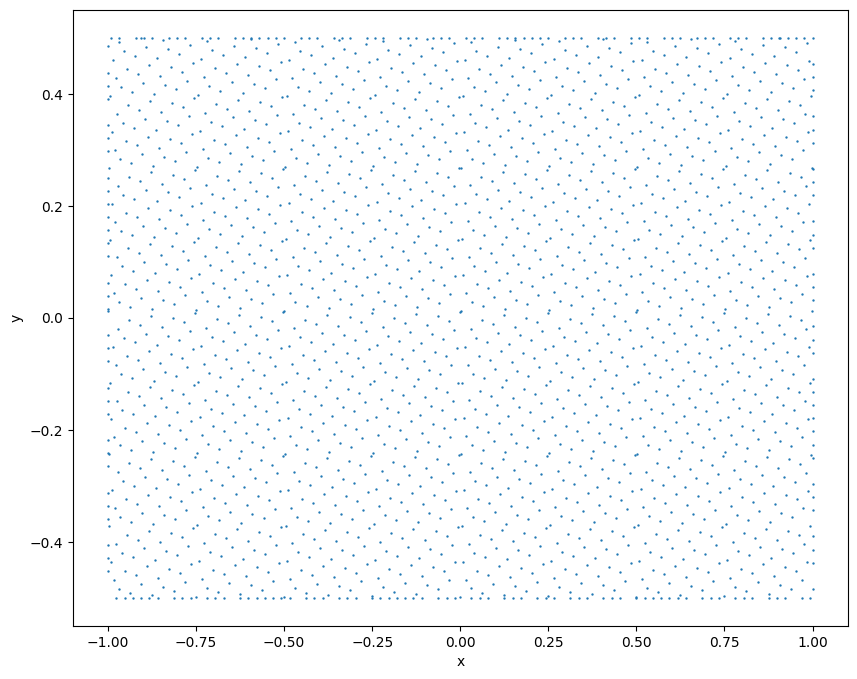

In [17]:
plt.figure(figsize=(10, 8))
plt.scatter(data.train_x_all[:, 0], data.train_x_all[:, 1], s=0.5)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

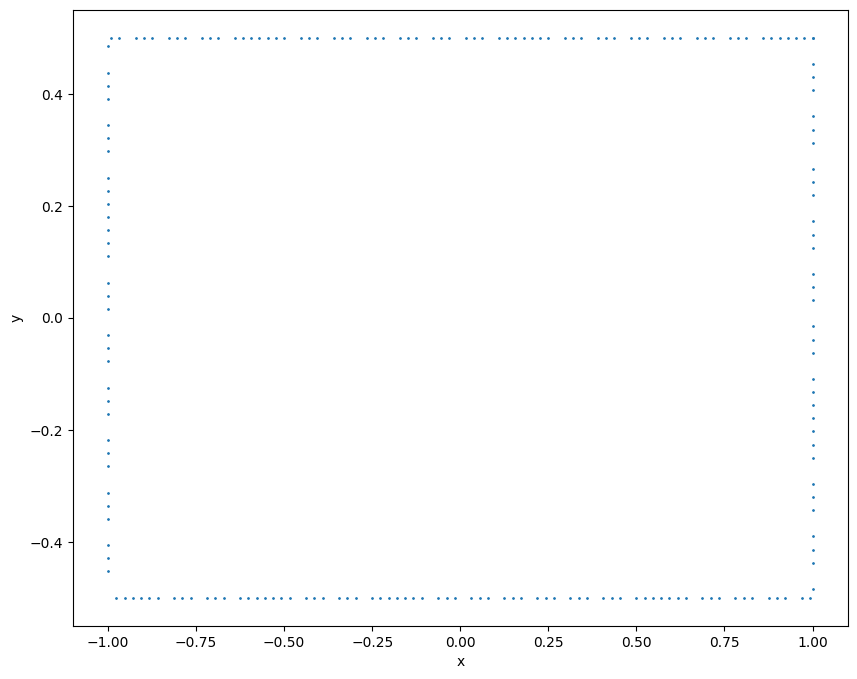

In [18]:
plt.figure(figsize=(10, 8))
plt.scatter(data.train_x_bc[:, 0], data.train_x_bc[:, 1], s=0.5)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

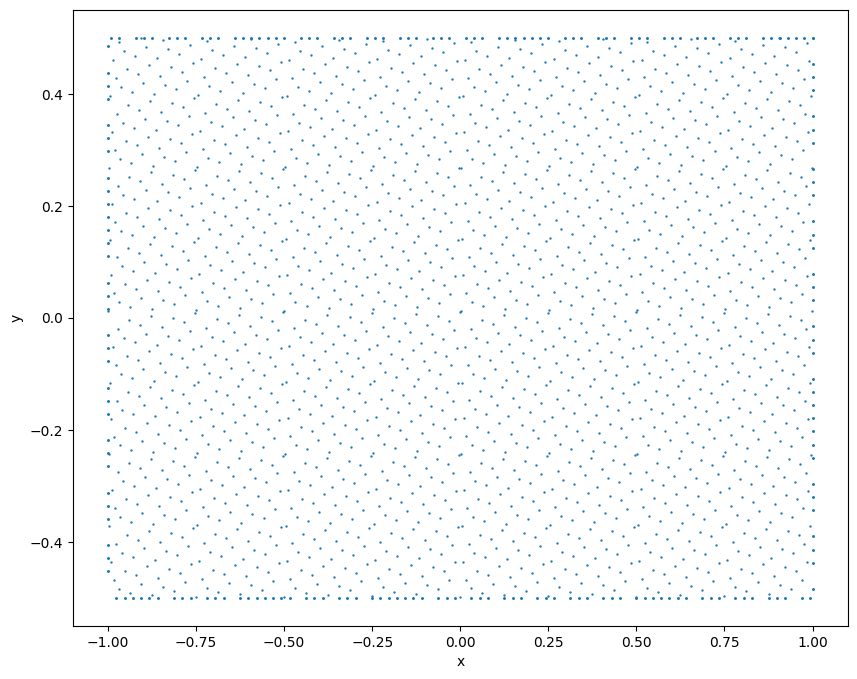

In [19]:
plt.figure(figsize=(10, 8))
plt.scatter(data.train_x[:, 0], data.train_x[:, 1], s=0.5)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [20]:
data.train_x.shape, data.train_x_bc.shape, data.train_x_all.shape

((2602, 2), (402, 2), (2200, 2))

In [21]:
net = dde.maps.FNN([2] + [64]*5 + [3], "tanh", "Glorot uniform") 

## Training

In [22]:
model = dde.Model(data, net)
model.compile('adam', lr=1e-3)

Compiling model...
Building feed-forward neural network...
'build' took 0.055781 s



c:\Users\Yerzhan\python_projects\env\lib\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.851174 s



In [23]:
losshistory, train_state = model.train(epochs=10000)

Training model...

Step      Train loss                                                                                    Test loss                                                                                     Test metric
0         [1.40e-02, 2.84e-02, 4.35e-02, 2.09e-03, 4.73e-03, 1.16e+00, 2.21e-03, 1.12e-02, 2.43e-03]    [1.40e-02, 2.92e-02, 4.47e-02, 2.09e-03, 4.73e-03, 1.16e+00, 2.21e-03, 1.12e-02, 2.43e-03]    []  
1000      [2.25e-02, 2.07e-03, 8.88e-03, 2.75e-02, 1.55e-02, 3.56e-02, 1.05e-03, 3.31e-03, 1.51e-04]    [2.19e-02, 1.94e-03, 5.22e-03, 2.75e-02, 1.55e-02, 3.56e-02, 1.05e-03, 3.31e-03, 1.51e-04]    []  
2000      [1.50e-03, 5.60e-04, 4.52e-03, 2.13e-02, 1.12e-02, 2.94e-02, 7.25e-04, 2.12e-04, 4.41e-05]    [1.20e-03, 2.35e-04, 2.34e-03, 2.13e-02, 1.12e-02, 2.94e-02, 7.25e-04, 2.12e-04, 4.41e-05]    []  
3000      [4.87e-03, 1.12e-03, 3.65e-03, 1.91e-02, 9.72e-03, 2.17e-02, 2.06e-03, 1.84e-03, 2.90e-06]    [4.80e-03, 6.83e-04, 1.88e-03, 1.91e-02, 9.72e-03, 2.17e-0

In [24]:
dde.optimizers.config.set_LBFGS_options(maxiter=3000)
model.compile("L-BFGS")
losshistory, train_state = model.train()

Compiling model...
'compile' took 0.450093 s

Training model...

Step      Train loss                                                                                    Test loss                                                                                     Test metric
10000     [4.48e-03, 1.13e-03, 2.13e-03, 1.45e-02, 5.41e-03, 1.45e-02, 5.24e-03, 8.19e-04, 1.79e-05]    [3.74e-03, 9.88e-04, 7.12e-04, 1.45e-02, 5.41e-03, 1.45e-02, 5.24e-03, 8.19e-04, 1.79e-05]    []  
11000     [7.76e-04, 8.36e-04, 6.94e-04, 7.83e-03, 1.38e-03, 6.06e-03, 2.60e-03, 1.06e-05, 7.96e-06]    [7.76e-04, 8.36e-04, 6.94e-04, 7.83e-03, 1.38e-03, 6.06e-03, 2.60e-03, 1.06e-05, 7.96e-06]        
12000     [4.14e-04, 3.20e-04, 5.25e-04, 4.58e-03, 9.80e-04, 4.24e-03, 1.44e-03, 1.48e-05, 7.04e-06]    [4.14e-04, 3.20e-04, 5.25e-04, 4.58e-03, 9.80e-04, 4.24e-03, 1.44e-03, 1.48e-05, 7.04e-06]        
13000     [5.14e-04, 2.90e-04, 4.89e-04, 3.56e-03, 8.55e-04, 2.99e-03, 7.13e-04, 1.79e-05, 3.56e-06]    [5.14e-04, 2

Saving loss history to c:\Users\Yerzhan\python_projects\PINN_courses\Physics Informed Neural Network (PINNs)\PINN_deepxde_2D_Navier_Stockes\loss.dat ...
Saving training data to c:\Users\Yerzhan\python_projects\PINN_courses\Physics Informed Neural Network (PINNs)\PINN_deepxde_2D_Navier_Stockes\train.dat ...
Saving test data to c:\Users\Yerzhan\python_projects\PINN_courses\Physics Informed Neural Network (PINNs)\PINN_deepxde_2D_Navier_Stockes\test.dat ...


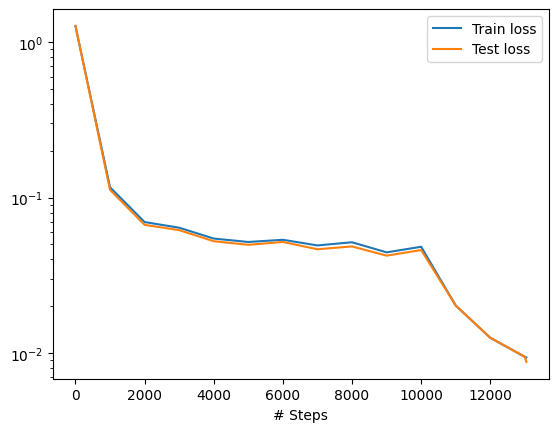

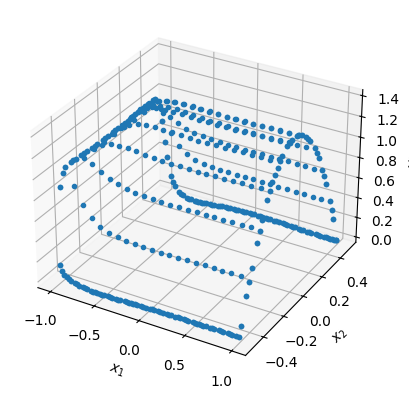

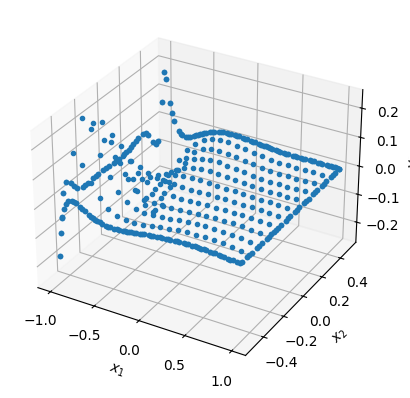

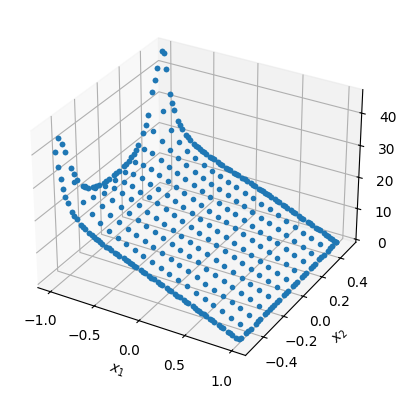

In [27]:
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

## Results evaluation and visualizations

In [28]:
samples = geom.random_points(50000)
output = model.predict(samples)

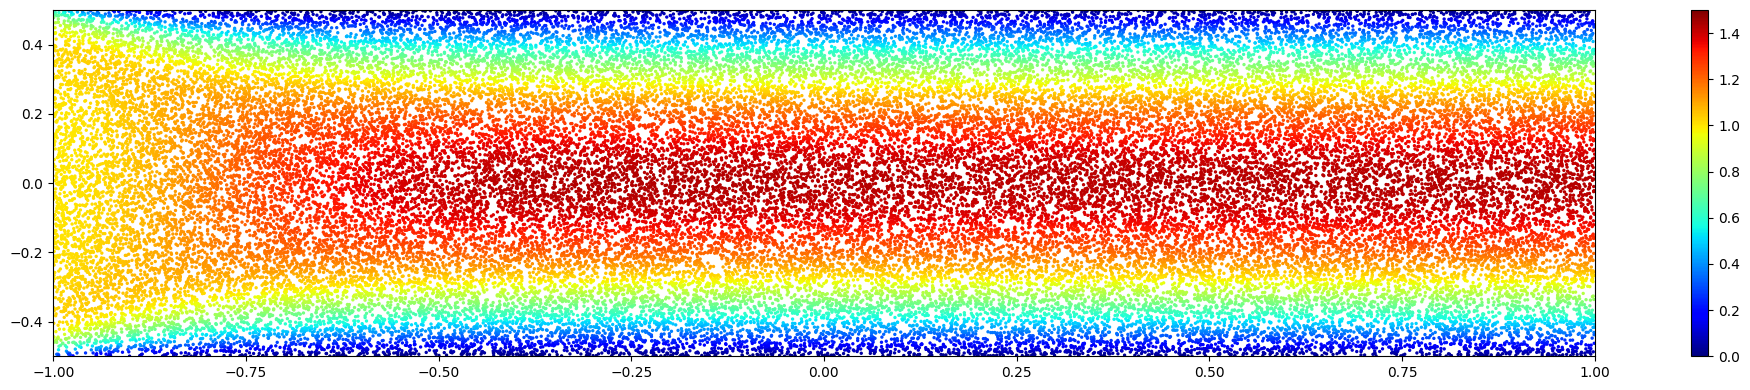

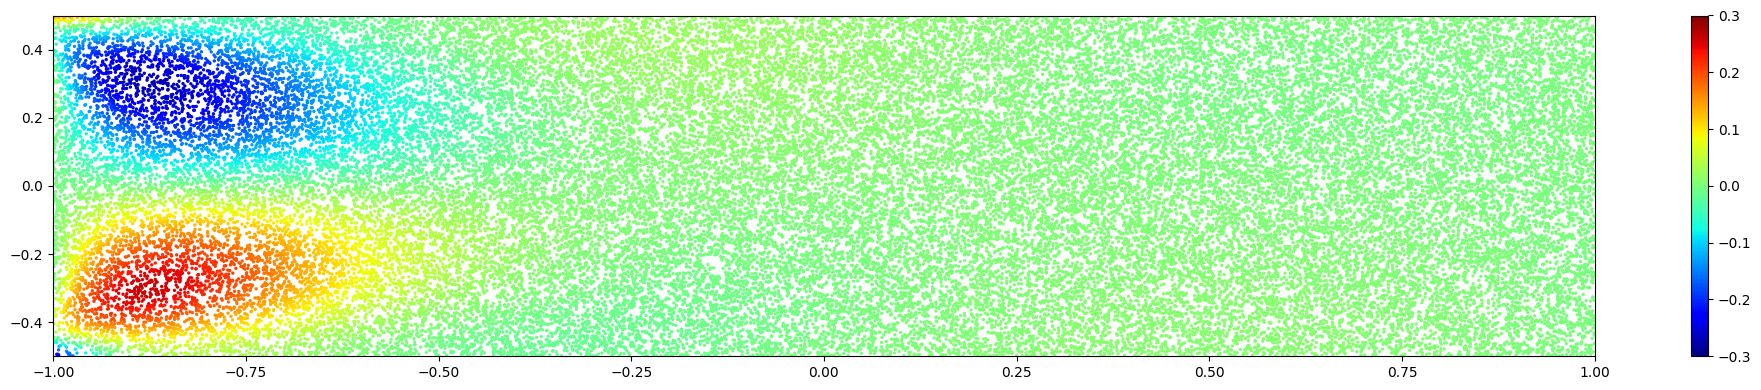

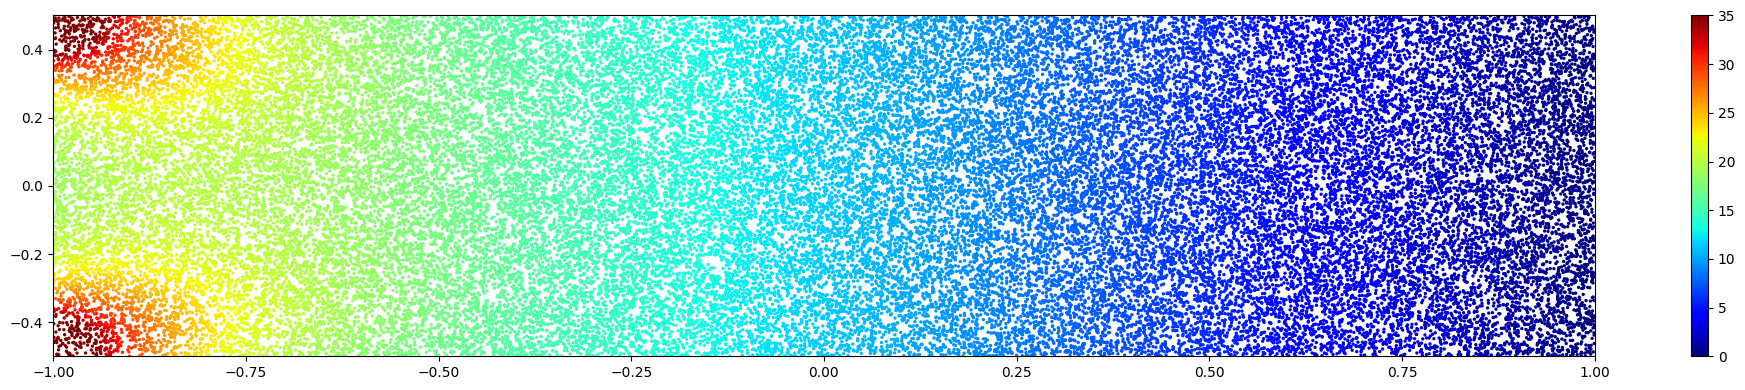

In [31]:
color_legend = [[0, 1.5], [-0.3, 0.3], [0, 35]]

for idx in range(3):
    plt.figure(figsize=(20, 4))
    plt.scatter(samples[:, 0], samples[:, 1], c=output[:, idx], 
                cmap='jet',
                s=2)
    plt.colorbar()
    plt.clim(color_legend[idx])
    plt.xlim((0-L/2, L-L/2))
    plt.ylim((0-D/2, D-D/2))
    plt.tight_layout()
    plt.savefig(f'figure_{idx}.png')
    plt.show()